In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization 

2024-02-26 17:39:06.478406: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-26 17:39:06.478543: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-26 17:39:06.656278: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TRAIN_DIR="/kaggle/input/facial-expression-dataset/train/train/"
TEST_DIR="/kaggle/input/facial-expression-dataset/test/test/"

In [3]:
def load_imgdata(directory):
    image_paths=[]
    labels=[]
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path=os.path.join(directory,label,filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label,"Completed")

    return image_paths,labels

In [4]:
train = pd.DataFrame()
train['image'],train['label']=load_imgdata(TRAIN_DIR)
train=train.sample(frac=1).reset_index(drop=True)
train.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/train/...,fear
1,/kaggle/input/facial-expression-dataset/train/...,neutral
2,/kaggle/input/facial-expression-dataset/train/...,angry
3,/kaggle/input/facial-expression-dataset/train/...,fear
4,/kaggle/input/facial-expression-dataset/train/...,neutral


In [5]:
test=pd.DataFrame()
test['image'], test['label']=load_imgdata(TEST_DIR)
test.head()

surprise Completed
fear Completed
angry Completed
neutral Completed
sad Completed
disgust Completed
happy Completed


,image,label
0,/kaggle/input/facial-expression-dataset/test/t...,surprise
1,/kaggle/input/facial-expression-dataset/test/t...,surprise
2,/kaggle/input/facial-expression-dataset/test/t...,surprise
3,/kaggle/input/facial-expression-dataset/test/t...,surprise
4,/kaggle/input/facial-expression-dataset/test/t...,surprise


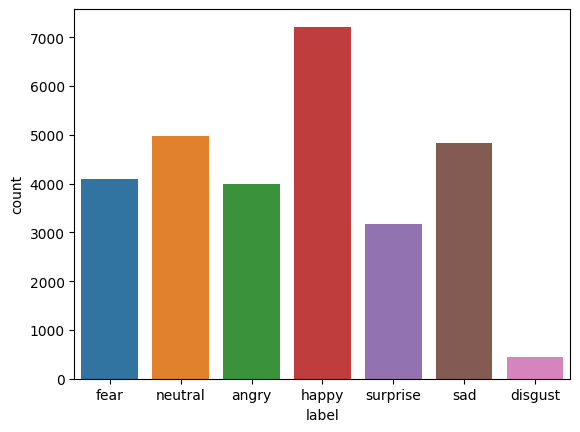

In [6]:
sns.countplot(data=train, x='label')
plt.show()

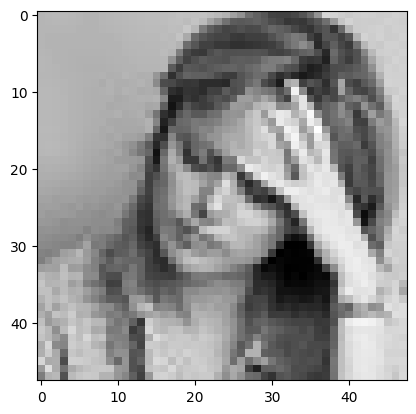

In [7]:
from PIL import Image
img=Image.open(train['image'][0])
plt.imshow(img,cmap='gray');

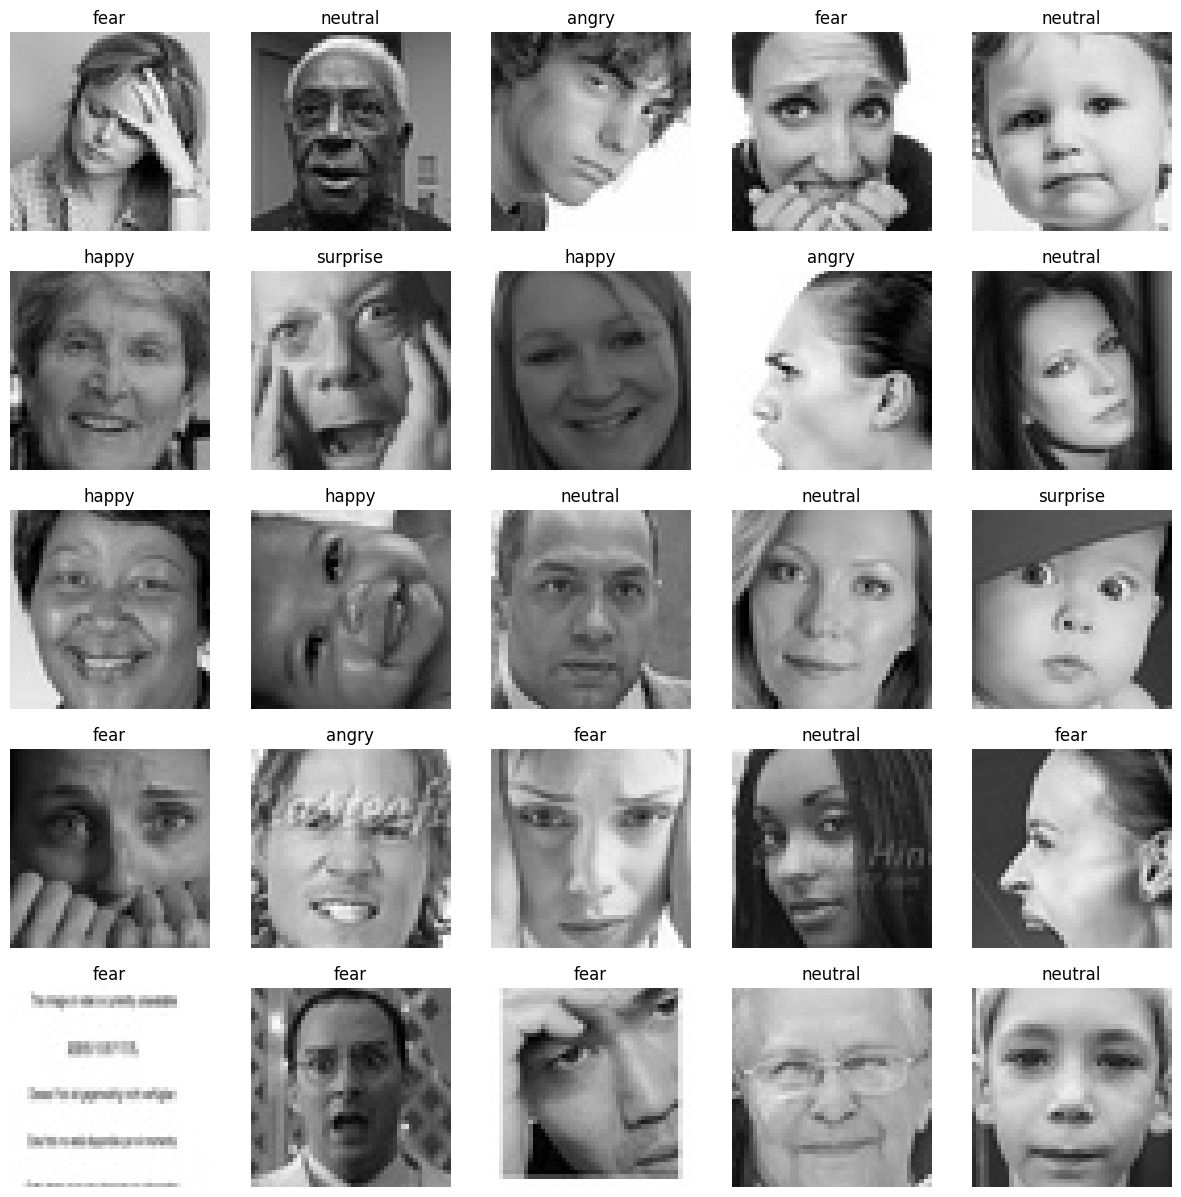

In [8]:
plt.figure(figsize=(15,15))
files=train.iloc[0:25]
for idx, file, label in files.itertuples():
    plt.subplot(5,5,idx+1)
    image=load_img(file)
    image=np.array(image)
    plt.imshow(image,cmap='gray')
    plt.title(label)
    plt.axis('off')

In [9]:
def extract_features(images):
    features=[]
    for file in tqdm(images):
        img=load_img(file,grayscale=True)
        img=np.array(img)
        features.append(img)
    features=np.array(features).reshape(len(features),48,48,1)
    return features

In [10]:
feat_train=extract_features(train['image'])

  0%|          | 0/28709 [00:00<?, ?it/s]

In [11]:
feat_test=extract_features(test['image'])

  0%|          | 0/7178 [00:00<?, ?it/s]

In [12]:
X_train=feat_train/255.0
X_test=feat_test/255.0

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(train['label'])
y_test = le.transform(test['label'])

In [14]:
from tensorflow.keras.utils import to_categorical

y_train=to_categorical(y_train,num_classes=7)
y_test=to_categorical(y_test,num_classes=7)

In [15]:
model=Sequential([
    Conv2D(filters=128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv2D(filters=256, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.25),
    
    Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.3),
    
    Conv2D(filters=512, kernel_size=(3,3), activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),
    Dropout(0.32),
    
    Flatten(),
    
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(units=512, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Dense(units=7, activation='softmax')
])

In [16]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'])

In [17]:
history=model.fit(x=X_train,y=y_train,batch_size=128,epochs=50,validation_data=(X_test,y_test))

Epoch 1/50


2024-02-26 17:44:31.853455: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1708969476.724256     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 [==============================] - 26s 64ms/step - loss: 2.0618 - accuracy: 0.2419 - val_loss: 2.0503 - val_accuracy: 0.2471
Epoch 2/50
225/225 [==============================] - 13s 56ms/step - loss: 1.5922 - accuracy: 0.3956 - val_loss: 1.6264 - val_accuracy: 0.2997
Epoch 3/50
225/225 [==============================] - 13s 56ms/step - loss: 1.3677 - accuracy: 0.4781 - val_loss: 1.3373 - val_accuracy: 0.4758
Epoch 4/50
225/225 [==============================] - 13s 56ms/step - loss: 1.2352 - accuracy: 0.5345 - val_loss: 1.2431 - val_accuracy: 0.5262
Epoch 5/50
225/225 [==============================] - 13s 57ms/step - loss: 1.1547 - accuracy: 0.5626 - val_loss: 1.1867 - val_accuracy: 0.5451
Epoch 6/50
225/225 [==============================] - 13s 57ms/step - loss: 1.0835 - accuracy: 0.5928 - val_loss: 1.3138 - val_accuracy: 0.5219
Epoch 7/50
225/225 [==============================] - 13s 58ms/step - loss: 1.0215 - accuracy: 0.6124 - val_loss: 1.6840 - val_accuracy: 0.4590
Epo

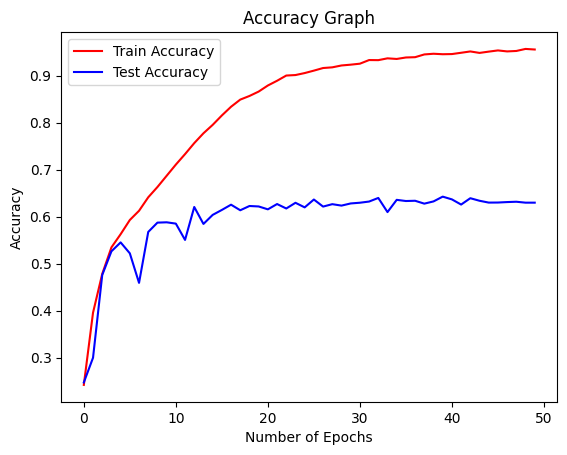

In [23]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
epochs=range(len(accuracy))

plt.plot(epochs,accuracy,'r',label='Train Accuracy')
plt.plot(epochs,val_accuracy,'b',label='Test Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend();

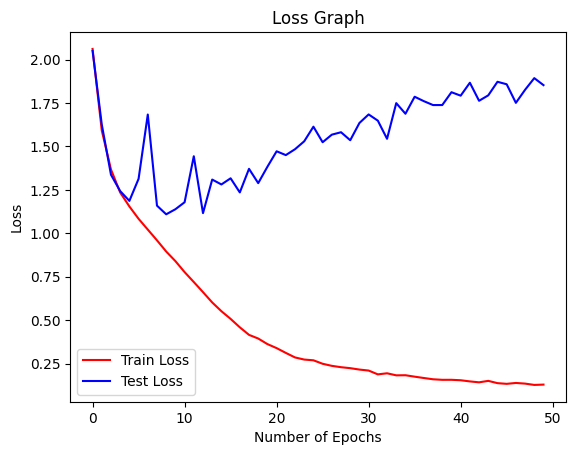

In [26]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(loss))

plt.plot(epochs,loss,'r',label='Train Loss')
plt.plot(epochs,val_loss,'b',label='Test Loss')
plt.title('Loss Graph')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend();

Original Output Label: sad
1/1 [==============================] - 0s 18ms/step
Predicted O/p Label: sad


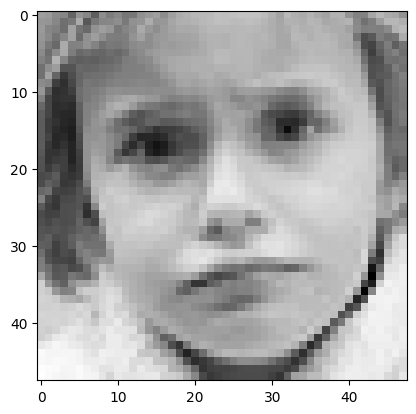

In [32]:
import random

img_indx=random.randint(0,len(test))
print("Original Output Label:", test['label'][img_indx])
pred=model.predict(X_test[img_indx].reshape(1,48,48,1))
predicted_label=le.inverse_transform([pred.argmax()])[0]
print("Predicted O/p Label:", predicted_label)
plt.imshow(X_test[img_indx].reshape(48,48),cmap='gray');

In [33]:
model.save("Face_Emotion.h5")

In [34]:
from keras.models import load_model
loaded_model=load_model("Face_Emotion.h5")

Original Output Label: angry
1/1 [==============================] - 0s 160ms/step
Predicted O/p Label: angry


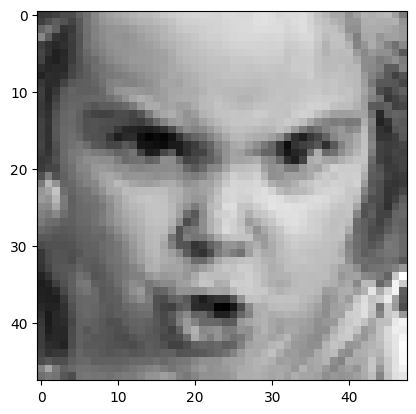

In [35]:
import random

img_indx=random.randint(0,len(test))
print("Original Output Label:", test['label'][img_indx])
pred=loaded_model.predict(X_test[img_indx].reshape(1,48,48,1))
predicted_label=le.inverse_transform([pred.argmax()])[0]
print("Predicted O/p Label:", predicted_label)
plt.imshow(X_test[img_indx].reshape(48,48),cmap='gray');